In [1]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
import pandas as pd

def pol2cart(r, tet, phi):
    x = r*np.sin(tet)*np.cos(phi)
    y = r*np.sin(tet)*np.sin(phi)
    z = r*np.cos(tet)
    return x,y,z

def cart2pol(vec):
    x = vec[0]
    y = vec[1]
    z = vec[2]
    r = np.linalg.norm(vec)
    tet = np.arccos(z/r)
    phi = np.arctan(y/x)
    return r, tet, phi

def r_ort(tet, phi):
    x = np.sin(tet)*np.cos(phi)
    y = np.sin(tet)*np.sin(phi)
    z = np.cos(tet)
    return np.array([x, y, z])

def tet_ort(tet, phi):
    x = np.cos(tet)*np.cos(phi)
    y = np.cos(tet)*np.sin(phi)
    z = -np.sin(tet)
    return np.array([x, y, z])

def phi_ort(tet, phi):
    x = -np.sin(phi)
    y = np.cos(phi)
    z = 0
    return np.array([x, y, z])


In [2]:
class Material:
    def __init__(self, Ms, gamma=5e8, alpha=0.018, Hkeff=6100.0, t=5e-9):
        self.Ms = Ms
        self.gamma = gamma
        self.alpha = alpha
        self.Hkeff = Hkeff
        self.t = t

        
class LayeredFilm:
    def __init__(self, layer1, layer2, J):
        self.l1 = layer1
        self.l2 = layer2
        self.J = J


def Demagnetization_Heff(M):
    return np.array([0.0, 0.0, M[2]])

        
def StonerWohlfarth_Heff(M, Hkeff):
    Mx, My, Mz = M
    x = -0.5*Hkeff*Mx*Mz**2/(np.linalg.norm(M)**3)
    y = -0.5*Hkeff*My*Mz**2/(np.linalg.norm(M)**3)
    z = Hkeff*Mz*(1.0*Mx**2 + 1.0*My**2 + 0.5*Mz**2)/(np.linalg.norm(M)**3)
    
    return np.array([x, y, z])


def IEC_Heff1(M1, M2, J, mu0, t1):
    K = J/(mu0*t1)
    first = M1.dot(M2)/((np.linalg.norm(M1)**3)*np.linalg.norm(M2))
    second = 1.0/(np.linalg.norm(M1)*np.linalg.norm(M2))
    return K*(M1*first-M2*second)

def IEC_Heff2(M1, M2, J, mu0, t2):
    return IEC_Heff1(M2, M1, J, mu0, t2)

In [3]:
import sympy as sym
from sympy import symbols, simplify, lambdify
from sympy.vector import CoordSys3D, matrix_to_vector

class LLG_EQ:
    def __init__(self):
        S = CoordSys3D('S')
        
        x, y, z = symbols('x y z')
        dMdt = x*S.i + y*S.j + z*S.k
        
        Mx, My, Mz = symbols('Mx My Mz')
        M = Mx*S.i + My*S.j + Mz*S.k
        
        Hx, Hy, Hz = symbols('Hx Hy Hz')
        H = Hx*S.i + Hy*S.j + Hz*S.k
        
        g = sym.Symbol('g')
        a = sym.Symbol('a')
        Ms = sym.Symbol('Ms')
        
        vec_eq = -dMdt - g*M.cross(H)+(a/Ms)*(M.cross(dMdt))
        sol = sym.solve(vec_eq.to_matrix(S), dMdt.to_matrix(S))
        
        sol[x] = simplify(sol[x])
        sol[y] = simplify(sol[y])
        sol[z] = simplify(sol[z])
        
        self.sol_lamb = dict()
        lambda_var_set = (
            a, g, Ms, 
            Mx, My, Mz, 
            Hx, Hy, Hz)
        
        self.sol_lamb['x'] = lambdify(lambda_var_set, sol[x], 'numpy')
        self.sol_lamb['y'] = lambdify(lambda_var_set, sol[y], 'numpy')
        self.sol_lamb['z'] = lambdify(lambda_var_set, sol[z], 'numpy')
        
        symbs = [x, y, z]
        dsymbs = [Mx, My, Mz]
        self.jac_mat = []
        for i in range(3):
            jac_row = []
            for j in range(3):
                jac_row.append(
                    lambdify(
                        lambda_var_set, 
                        simplify(sol[symbs[i]].diff(dsymbs[j]))
                    )
                )
            self.jac_mat.append(jac_row)
    
    def right_hand(self, Heff, M, layer):
        x = self.sol_lamb['x'](
            layer.alpha, layer.gamma, np.linalg.norm(M),
            M[0], M[1], M[2], Heff[0], Heff[1], Heff[2]
        )
        y = self.sol_lamb['y'](
            layer.alpha, layer.gamma, np.linalg.norm(M),
            M[0], M[1], M[2], Heff[0], Heff[1], Heff[2]
        )
        z = self.sol_lamb['z'](
            layer.alpha, layer.gamma, np.linalg.norm(M),
            M[0], M[1], M[2], Heff[0], Heff[1], Heff[2]
        )
        return [x, y, z]
    
    #not allowed for multilayer no
    def jacobian(self, M, Heff, film):
        ret = np.zeros((3,3))
        for i in range(3):
            for j in range(3):
                ret[i][j] = self.jac_mat[i][j](
                    film.alpha, film.gamma, np.linalg.norm(M),
                    M[0], M[1], M[2], Heff[0], Heff[1], Heff[2]
                )
        return ret
             
    


In [11]:
mu0 = 1.2566370621219e-6
layer1 = Material(1042e3, gamma=1.76e11*mu0, alpha=0.000)
layer2 = Material(1042e3, gamma=1.76e11*mu0, alpha=0.000)
film_inst = LayeredFilm(layer1, layer2, 2.7e-3)
equation = LLG_EQ()

Hext = np.array(pol2cart(110e-3/mu0, np.deg2rad(90.0), 0.0))
#Hext = np.array([0.0,0.0,0.0])
#Hext = np.array([160e-3/mu0,0.0,0.0])


def Heff_function(M1, M2, film):
    #Heff1 = Hext + IEC_Heff1(M1, M2, film.J, mu0, film.l1.t)
    #Heff2 = Hext + IEC_Heff2(M1, M2, film.J, mu0, film.l2.t)
    Heff1 = Hext + Demagnetization_Heff(M1) + IEC_Heff1(M1, M2, film.J, mu0, film.l1.t)
    Heff2 = Hext + Demagnetization_Heff(M2) + IEC_Heff2(M1, M2, film.J, mu0, film.l2.t)
    #Heff1 = Hext + StonerWohlfarth_Heff(M1, film.l1.Hkeff) + IEC_Heff1(M1, M2, film.J, mu0, film.l1.t)
    #Heff2 = Hext + StonerWohlfarth_Heff(M2, film.l2.Hkeff) + IEC_Heff2(M1, M2, film.J, mu0, film.l2.t)
    return Heff1, Heff2


def model(t,M1_M2):
    M1 = M1_M2[0:3]
    M2 = M1_M2[3:6]
    
    Heff1, Heff2 = Heff_function(M1, M2, film_inst)
    
    LLG1 = equation.right_hand(Heff1, M1, film_inst.l1)
    LLG2 = equation.right_hand(Heff2, M2, film_inst.l2)
    
    return np.append(LLG1, LLG2)

#fi_tmp = np.arccos(mu0*(110e-3/mu0)*film_inst.l1.Ms*film_inst.l1.t/(2.0*film_inst.J))
#print(np.rad2deg(fi_tmp))
M01 = pol2cart(film_inst.l1.Ms, np.deg2rad(3.0), np.deg2rad(0.0))
M02 = pol2cart(film_inst.l2.Ms, np.deg2rad(177.0), np.deg2rad(0.0))
M01_M02 = np.append(M01, M02)


time_span = [0.0, 1000.0e-12]
sol = solve_ivp(model, time_span, M01_M02,t_eval=np.linspace(time_span[0], time_span[1],100000),
                method = 'RK45', max_step=1e-13)


df = pd.DataFrame()
df['t'] = sol.t

df['x1'] = sol.y[0]
df['y1'] = sol.y[1]
df['z1'] = sol.y[2]
df['r1'] = np.sqrt(df['x1']**2+df['y1']**2+df['z1']**2)

df['x2'] = sol.y[3]
df['y2'] = sol.y[4]
df['z2'] = sol.y[5]
df['r2'] = np.sqrt(df['x2']**2+df['y2']**2+df['z2']**2)
df

,t,x1,y1,z1,r1,x2,y2,z2,r2
0,0.000000e+00,54534.066405,0.000000,1.040572e+06,1042000.0,54534.066405,0.000000,-1.040572e+06,1042000.0
1,1.000010e-14,54534.039484,23.394751,1.040572e+06,1042000.0,54534.039484,-23.394751,-1.040572e+06,1042000.0
2,2.000020e-14,54533.958722,46.789280,1.040572e+06,1042000.0,54533.958722,-46.789280,-1.040572e+06,1042000.0
3,3.000030e-14,54533.824120,70.183365,1.040572e+06,1042000.0,54533.824120,-70.183365,-1.040572e+06,1042000.0
4,4.000040e-14,54533.635678,93.576784,1.040572e+06,1042000.0,54533.635678,-93.576784,-1.040572e+06,1042000.0
...,...,...,...,...,...,...,...,...,...
99995,9.999600e-10,54384.634298,1731.484416,1.040578e+06,1042000.0,54384.634298,-1731.484416,-1.040578e+06,1042000.0
99996,9.999700e-10,54380.623166,1754.254965,1.040579e+06,1042000.0,54380.623166,-1754.254965,-1.040579e+06,1042000.0
99997,9.999800e-10,54376.559647,1777.008871,1.040579e+06,1042000.0,54376.559647,-1777.008871,-1.040579e+06,1042000.0
99998,9.999900e-10,54372.443780,1799.745918,1.040579e+06,1042000.0,54372.443780,-1799.745918,-1.040579e+06,1042000.0


<IPython.core.display.Javascript object>


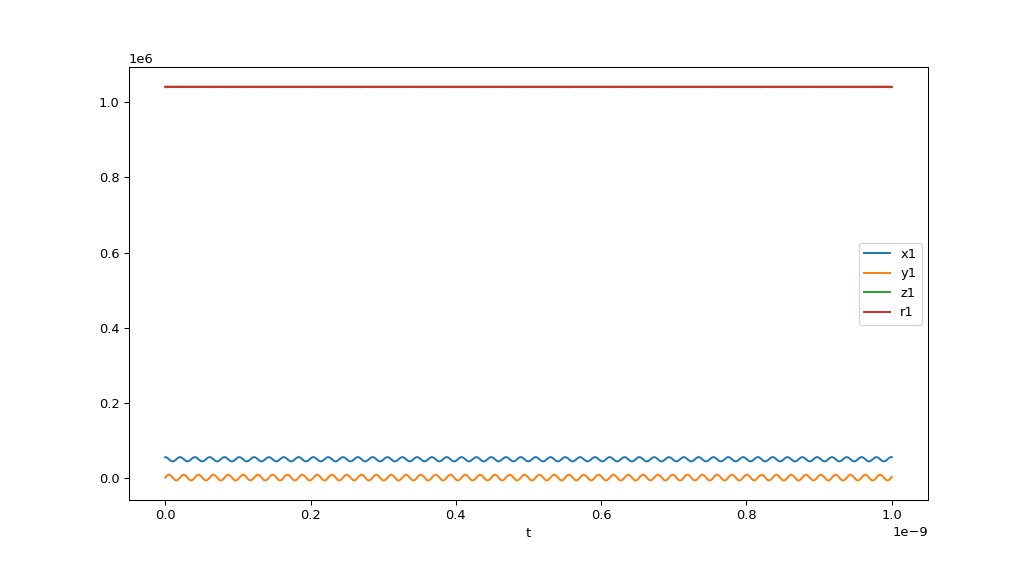

<AxesSubplot:xlabel='t'>

In [12]:
# %matplotlib inline
%matplotlib notebook
#%matplotlib qt

df.plot(x='t', y=['x1', 'y1', 'z1', 'r1'], figsize = (11, 6))

<IPython.core.display.Javascript object>


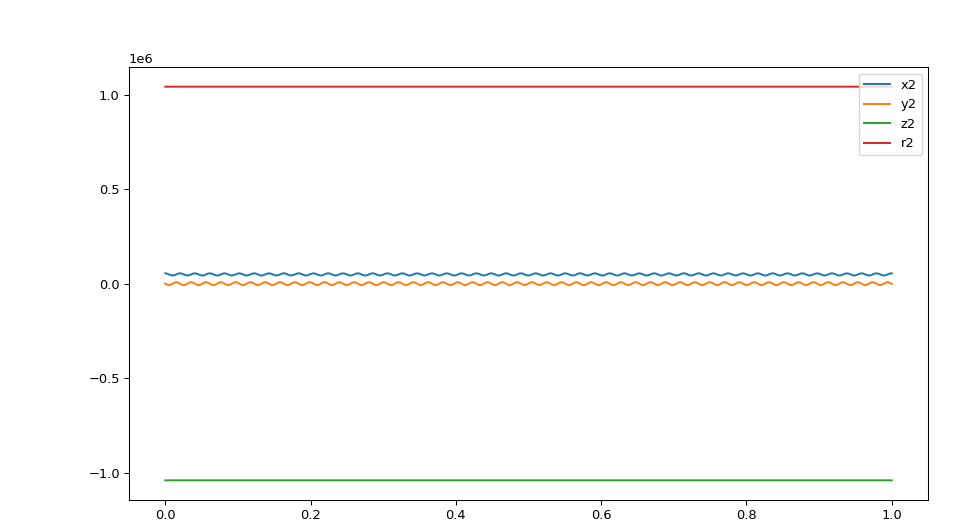

<AxesSubplot:xlabel='t'>

In [13]:
# %matplotlib inline
%matplotlib notebook
#%matplotlib qt

df.plot(x='t', y=['x2', 'y2', 'z2', 'r2'], figsize = (11, 6))

<IPython.core.display.Javascript object>


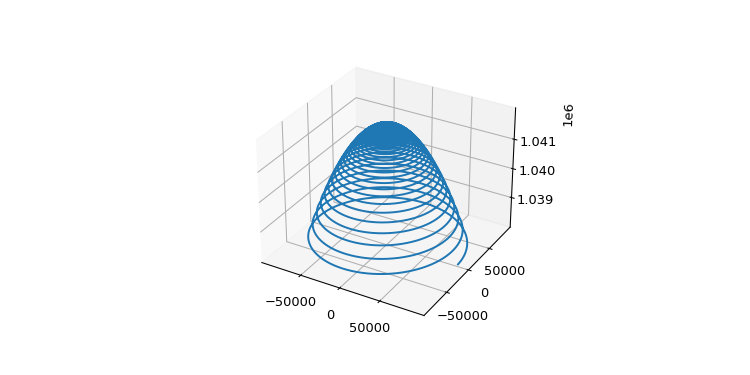

In [10]:
#%matplotlib inline
%matplotlib notebook
#%matplotlib qt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,4), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection='3d')
ax.plot(sol.y[0], sol.y[1], sol.y[2])

<IPython.core.display.Javascript object>


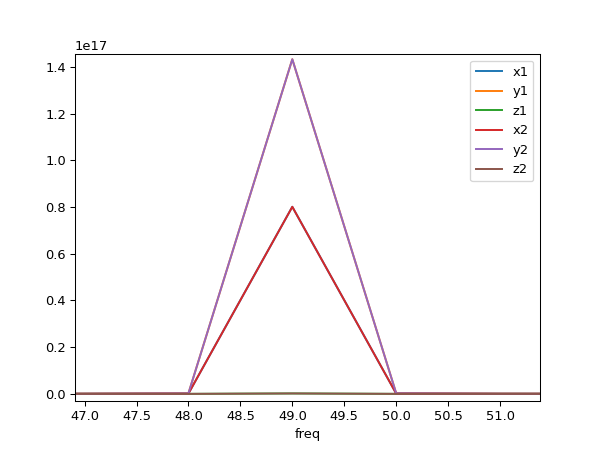

,freq,x1,y1,z1,x2,y2,z2
0,0.99999,2.004611e+11,5.475328e+09,4.223157e+08,2.004611e+11,5.475328e+09,4.223157e+08
1,1.99998,2.009662e+11,5.938216e+09,4.233977e+08,2.009662e+11,5.938216e+09,4.233977e+08
2,2.99997,2.018122e+11,6.714815e+09,4.252103e+08,2.018122e+11,6.714815e+09,4.252103e+08
3,3.99996,2.030055e+11,7.812906e+09,4.277672e+08,2.030055e+11,7.812906e+09,4.277672e+08
4,4.99995,2.045554e+11,9.243587e+09,4.310882e+08,2.045554e+11,9.243587e+09,4.310882e+08
...,...,...,...,...,...,...,...
9994,9994.90005,7.397967e+04,8.925900e+06,1.349011e+02,7.397967e+04,8.925900e+06,1.349011e+02
9995,9995.90004,7.396533e+04,8.924173e+06,1.348750e+02,7.396533e+04,8.924173e+06,1.348750e+02
9996,9996.90003,7.395100e+04,8.922447e+06,1.348489e+02,7.395100e+04,8.922447e+06,1.348489e+02
9997,9997.90002,7.393667e+04,8.920721e+06,1.348227e+02,7.393667e+04,8.920721e+06,1.348227e+02


In [14]:
%matplotlib notebook
freq_df = pd.DataFrame(columns=['freq','x1','y1','z1','x2','y2','z2'])

freq_df['freq'] = np.fft.fftfreq(len(df.t), df.t[1]-df.t[0])[1:10000] * 1e-9

column_names = ['x1','y1','z1','x2','y2','z2']
for name in column_names:
    freq_df[name] = np.abs(np.fft.fft(df[name]))[1:10000]**2

freq_df.plot(x='freq', y=['x1','y1', 'z1', 'x2', 'y2', 'z2'])
freq_df

In [13]:
film_inst.l1.gamma * 1042e3 * 1e-9

230.4571840966595

# Legacy Code

<IPython.core.display.Javascript object>


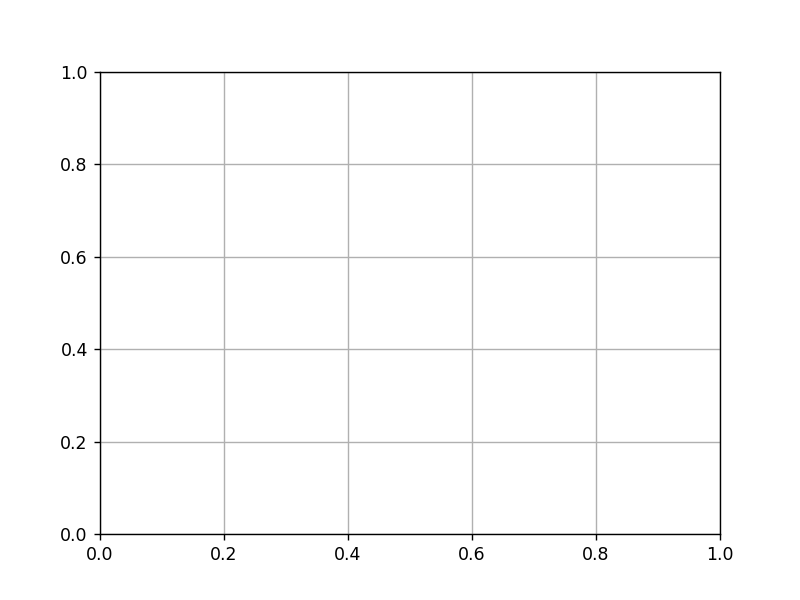

NameError: name 'heff' is not defined

In [101]:
%matplotlib notebook

#heff = [];
#for i in range(len(sol.t)):
#    heff.append(Heff(Hext, sol.y.T[i]))

#heff = np.array(heff).T

#ax.plot(heff[0], heff[1], heff[2])

plt.grid(True)
plt.plot(sol.t, heff[0])
plt.plot(sol.t, heff[1])
plt.plot(sol.t, heff[2])

In [12]:
import numpy as np
import sympy as sym
from sympy import symbols, simplify
from sympy.vector import CoordSys3D, matrix_to_vector, Del, gradient
S = CoordSys3D('S')

Mx, My, Mz = symbols("Mx My Mz")
M = Mx*S.i + My*S.j + Mz*S.k

Esh = -0.5*((M.dot(S.k))**2)
print(Esh)
print()
Heff = [-Esh.diff(Mx), -Esh.diff(My), -Esh.diff(Mz)]
for i in range(3):
    print(simplify(Heff[i]))

-0.5*Mz**2

0
0
1.0*Mz


In [66]:
import numpy as np
import sympy as sym
from sympy import symbols, simplify
from sympy.vector import CoordSys3D, matrix_to_vector, Del, gradient
S = CoordSys3D('S')

Mx1, My1, Mz1 = symbols("Mx1 My1 Mz1")
M1 = Mx1*S.i + My1*S.j + Mz1*S.k
Mx2, My2, Mz2 = symbols("Mx2 My2 Mz2")
M2 = Mx2*S.i + My2*S.j + Mz2*S.k
mu0_sym, J, tj = symbols("mu0 J tj")


Esh = (J/(mu0_sym*tj))*(M1.dot(M2)/(M1.magnitude()*M2.magnitude()))
print(simplify(Esh))
print()
Heff1 = [-Esh.diff(Mx1), -Esh.diff(My1), -Esh.diff(Mz1)]
for i in range(3):
    print(simplify(Heff1[i]))

M, tet1, tet2, A = symbols("M tet1 tet2 A") 
mx, my, mz = symbols("mx my mz")

simplify(Heff1[0].subs({
    Mx1: M*sym.cos(tet1),
    My1: M*sym.sin(tet1),
    Mz1: 0,
    
    Mx2: M*sym.cos(tet2),
    My2: M*sym.sin(tet2),
    Mz2: 0,
    
    J: A*mu0_sym*tj*M*M
    
}))
    

J*(Mx1*Mx2 + My1*My2 + Mz1*Mz2)/(mu0*tj*sqrt(Mx1**2 + My1**2 + Mz1**2)*sqrt(Mx2**2 + My2**2 + Mz2**2))

J*(Mx1*My1*My2 + Mx1*Mz1*Mz2 - Mx2*My1**2 - Mx2*Mz1**2)/(mu0*tj*(Mx1**2 + My1**2 + Mz1**2)**(3/2)*sqrt(Mx2**2 + My2**2 + Mz2**2))
J*(-Mx1**2*My2 + Mx1*Mx2*My1 + My1*Mz1*Mz2 - My2*Mz1**2)/(mu0*tj*(Mx1**2 + My1**2 + Mz1**2)**(3/2)*sqrt(Mx2**2 + My2**2 + Mz2**2))
J*(-Mx1**2*Mz2 + Mx1*Mx2*Mz1 - My1**2*Mz2 + My1*My2*Mz1)/(mu0*tj*(Mx1**2 + My1**2 + Mz1**2)**(3/2)*sqrt(Mx2**2 + My2**2 + Mz2**2))


A*M*(-cos(tet2) + cos(2*tet1 - tet2))/2

In [63]:
expr = Mx+My
expr.subs({Mx: Mz, My:Mz})

2*Mz